In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
import xgboost as xgb

In [9]:
# Step 0: Load the csv files

xtrain = pd.read_csv("X_train.csv")
xtrain = xtrain.iloc[:, 1:]
xtest = pd.read_csv("X_test.csv")
xtest = xtest.iloc[:, 1:]
ytrain = pd.read_csv("Y_train.csv")

# Remove unnecessary id column from ytrain

ytrain = ytrain.drop(['id'], axis = 1)

# Take a look at original xtrain

print(xtrain.shape)
xtrain.head()

(1212, 832)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
0,118345.392781,3104.010883,82378.542430,1086.678601,11395.883550,10.455601,109886.476608,1.054926e+06,101877.946528,2.550290,...,10.769524,10.245068,1021.907543,1031.645762,107440.039766,107083.296966,5559.203921,10.861464,107548.413675,2.299202
1,NaN,5889.055991,97932.067482,1116.564363,12172.212426,10.502997,100372.504488,1.011783e+06,108852.296962,2.579040,...,10.859822,10.088023,988.135968,999.044639,105238.779040,106365.468525,10334.091649,NaN,107841.227180,2.472763
2,95373.022035,6293.442455,93371.369288,1034.722073,11618.142107,10.947611,109337.757279,1.006491e+06,104540.883376,2.573247,...,10.356015,10.514234,995.480813,898.329758,107044.005199,102704.104686,7697.875887,10.277760,103414.594212,NaN
3,105066.272301,3279.162164,119554.079514,1114.014483,12127.235755,10.540204,106215.391332,1.022381e+06,109597.474506,2.693256,...,10.609811,10.991861,1117.179063,867.267810,100617.082858,108893.304959,6549.131099,9.337688,105722.857008,2.484935
4,98957.033333,4177.482190,97239.708338,1049.430921,10417.250336,10.618957,102736.470171,1.086871e+06,103340.057448,2.540610,...,10.397777,NaN,863.943966,1041.278922,105352.672454,101705.692839,5388.312773,12.196382,NaN,1.930136


In [10]:
# Step 1: Treat missing values
# Treat missing values as column medians for outlier robustness. 
# Use the medians from the training set in the test set

xtrain = xtrain.fillna(xtrain.median())
xtest = xtest.fillna(xtrain.median())


In [11]:
# Step 2: Scale the training and test data

scaler = preprocessing.StandardScaler()

xtrain_scaled = scaler.fit_transform(xtrain)
xtrain = pd.DataFrame(xtrain_scaled, columns = xtrain.columns)
xtest_scaled = scaler.fit_transform(xtest)
xtest = pd.DataFrame(xtest_scaled, columns = xtest.columns)

# Now observe scaled data with imputed medians

xtrain.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
0,2.001809,-0.652740,-1.881312,0.917417,1.454476,-0.388651,1.845923,0.207084,-1.112274,0.275672,...,0.821172,-1.107227,0.249939,0.312998,0.903668,0.746658,-0.945093,0.892698,0.925679,0.149058
1,0.026926,2.406878,-0.211880,1.233120,2.265954,-0.210434,-1.732886,-1.383778,1.477544,0.467879,...,1.153362,-1.680678,-0.105167,-0.035149,0.099747,0.478875,2.612160,-0.039934,1.031616,1.217160
2,-0.500516,2.851133,-0.701401,0.368566,1.686798,1.461403,1.639515,-1.578885,-0.123433,0.429150,...,-0.700058,-0.124364,-0.027937,-1.110680,0.759032,-0.886982,0.648200,0.276651,-0.569888,0.107820
3,0.555346,-0.460321,2.108910,1.206184,2.218941,-0.070530,0.464995,-0.992993,1.754254,1.231450,...,0.233614,1.619696,1.251713,-1.442390,-1.588138,1.421875,-0.207605,-0.715512,0.265215,1.292065
4,-0.110118,0.526563,-0.286194,0.523945,0.431533,0.225598,-0.843648,1.384996,-0.569341,0.210957,...,-0.546425,-0.035512,-1.411038,0.415870,0.141342,-1.259435,-1.072406,2.301585,-0.031837,-2.122182


In [12]:
# Step 3 - Feature Selection: Remove features with zero weight from Lasso

clf = Lasso(alpha=0.3)
clf.fit(xtrain, ytrain)

features = (clf.coef_ != 0)

xtrain = xtrain.loc[:, features]
xtest = xtest.loc[:, features]

# Observe dimensionality reduction

print(xtrain.shape)

(1212, 94)


% of variance first PC:  0.10517221374447663
% of variance second PC:  0.07539335930672075


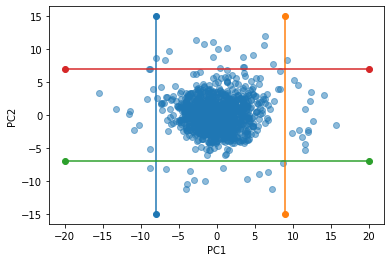

Remaining training examples: 1155


In [13]:
# Step 4 - Outlier Detection: Remove outliers based on PCA plot

# Decompose xtrain into two principal components

pca = decomposition.PCA(n_components=2)
principal_components = pca.fit_transform(xtrain)
xpca = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

# Inspect percentage of variance explained by the two PC's

print("% of variance first PC: ", pca.explained_variance_ratio_.item(0))
print("% of variance second PC: ", pca.explained_variance_ratio_.item(1))

# Draw plot with lines for outlier exclusion

plt.scatter(xpca['PC1'], xpca['PC2'], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.plot([-8, -8], [-15, 15], marker='o')
plt.plot([9, 9], [-15, 15], marker='o')
plt.plot([-20, 20], [-7, -7], marker='o')
plt.plot([-20, 20], [7, 7], marker='o')
plt.show()

# Exclude outlier points that fall outside of lines

outliers = (xpca['PC1'] <= 9) & (xpca['PC1'] >= -8) & (xpca['PC2'] <= 7) & (xpca['PC2'] >= -7)
print('Remaining training examples:', np.count_nonzero(outliers))
xtrain = xtrain[outliers]
ytrain = ytrain[outliers]

In [14]:
# Step 5 - Model Fit: XGBoost

clf = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Inspect performance on 5-fold Cross Validation sets (10 shuffled iterations)

cv_means = []
cv_stds = []
for i in np.arange(10):
    scores = cross_val_score(estimator = clf,
                                 X = xtrain,
                                 y = ytrain,
                                 scoring = 'r2',
                                 cv = KFold(n_splits=5, shuffle = True))
    cv_means.append(np.mean(scores))
    cv_stds.append(np.std(scores))

print("Average of R2 scores:", np.mean(cv_means))
print("Standard deviation of R2 scores:", np.mean(cv_stds))

Average of R2 scores: 0.6517167904612916
Standard deviation of R2 scores: 0.019927026465806706


In [8]:
# Step 6: Train model on all data and export csv

clf = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
clf.fit(xtrain, ytrain)

y_pred = clf.predict(xtest)

index = pd.read_csv("sample.csv")
index['y'] = y_pred

index.to_csv("PredictionsFinal.csv")